In [1]:
!pip install -U mpld3 matplotlib numpy

Requirement already up-to-date: mpld3 in /home/momma/miniconda3/envs/py3/lib/python3.8/site-packages (0.5.6)
Requirement already up-to-date: matplotlib in /home/momma/miniconda3/envs/py3/lib/python3.8/site-packages (3.5.0)
Requirement already up-to-date: numpy in /home/momma/miniconda3/envs/py3/lib/python3.8/site-packages (1.21.4)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3


mpld3.enable_notebook()

In [26]:
FOOD_STRENGTHS = {
    "red": 0.001,
    "green": 0.0025,
    "blue": 0.008,
    "black": 0.0225,
    "purple": 0.1050,
    "yellow": 0.1200,
    "white": 0.5,
}


def get_instant_threat_player_count_modifier(player_count):
    minimum_modifier = 125
    maximum_modifier = 250
    player_amount_for_maximum_threat_gain = 20
    gain_per_player = (
        maximum_modifier - minimum_modifier
    ) / player_amount_for_maximum_threat_gain
    m = minimum_modifier + gain_per_player * player_count
    if m > maximum_modifier:
        m = maximum_modifier
    return m


def evo_impact(science, player_count, flask_amount, current_evo, difficulty):
    instant_threat_player_count_modifier = get_instant_threat_player_count_modifier(
        player_count
    )
    food_value = FOOD_STRENGTHS[science] * difficulty
    threat = 0
    # Starting evo at 0 produces weird derivatives but whatever i guess
    evo_factor = 0
    evos = [current_evo]
    evo = current_evo
    for x in range(1, flask_amount + 1):
        e2 = (evo_factor * 100) + 1
        diminishing_modifier = (1 / (10 ** (e2 * 0.015))) / (e2 * 0.5)
        evo_gain = food_value * diminishing_modifier
        evo = evo + evo_gain
        if evo <= 1:
            evo_factor = evo
        else:
            evo_factor = 1
        diminishing_modifier = 1 / (0.2 + (e2 * 0.016))
        threat = threat + (
            food_value * instant_threat_player_count_modifier * diminishing_modifier
        )
        evos.append(evo)

    return evos

In [27]:
# torun = [
#     (("red", 2000)),
#     (("green", 2000)),
torun = [
    (
        ("red", 600),
        ("green", 1000),
        ("black", 700),
        ("purple", 1000),
        ("yellow", 700),
        ("white", 500),
    ),
]
difficulties = {
    "itytd": 0.25,
    "poc": 0.5,
    "easy": 0.75,
    "normal": 1.0,
    "hard": 1.5,
    "nightmare": 3,
    "fnf": 5,
}
fig, ax = plt.subplots(figsize=(13, 8))



player_count = 6
difficulty = difficulties["poc"]
for run_schema in torun:
    evos = []
    colors = []
    start = 1
    for science_name, science_count in run_schema:
        label = f"{science_name}-{science_count}"
        if evos:
            current_evo = evos[-1]
        else:
            current_evo = 0
        # colors += [science_name]*science_count
        this_evo = evo_impact(
            science_name, player_count, science_count, current_evo, difficulty
        )
        evos += this_evo
        plot_start = start - 1
        plot_x = range(plot_start, start + science_count)
        print(len(this_evo), len(plot_x))
        color = science_name
        if science_name == "white":
            color = "grey"
        ax.plot(plot_x, this_evo, color=color, label=label, linewidth=6)
        start += science_count
ax.legend()
mpld3.display(fig)

601 601
1001 1001
701 701
1001 1001
701 701
501 501


0.12130165100097656
for red to get 357005


TypeError: 'int' object is not iterable

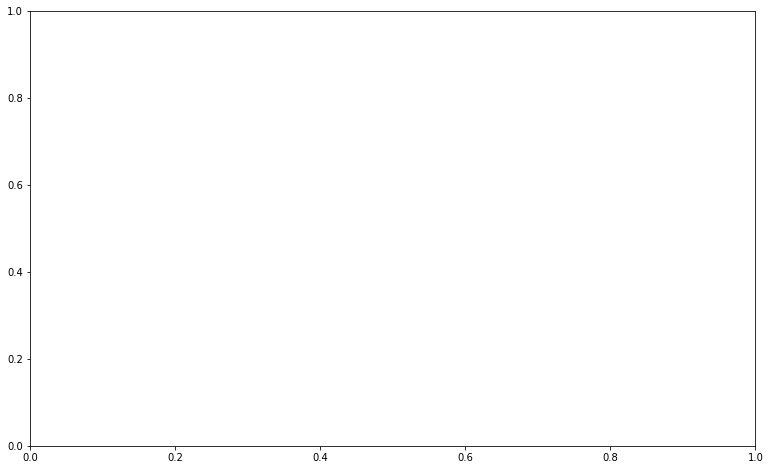